In [206]:
import torch
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import random
from IPython.display import clear_output
from multiprocessing.pool import ThreadPool
import scipy.stats as stats

In [207]:
class StatesEncoder(nn.Module):
    def __init__(self,input_dim):
        super(StatesEncoder,self).__init__()
        self.fc1 = nn.Linear(input_dim,512)
#         self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(512,256)
#         self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(256,64)
#         self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,1)
        
    def forward(self,obj):
        x = torch.FloatTensor(obj)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        enc = self.fc4(x)
        return enc

In [208]:
class ActorNet(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(ActorNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(128,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,64)
        self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,output_dim)
        
    def forward(self,obj,action=False,max_act=False):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        logits = self.fc4(x)
        m = Categorical(logits=logits)
        act = m.sample()
        log_p = m.log_prob(act)
        if action:
            return m.log_prob(torch.LongTensor(action))
        else:
            if max_act:
                return torch.argmax(logits).item()
            else:
                return m,act.item(),log_p

In [214]:
make = 'LunarLander-v2'

In [215]:
env = gym.make(make)

In [216]:
input_dim = env.observation_space.shape[0]

In [217]:
output_dim = env.action_space.n

In [218]:
act_net = ActorNet(input_dim,output_dim)

In [219]:
class CriticNet(nn.Module):
    def __init__(self,input_dim):
        super(CriticNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(128,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,64)
        self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,1)
        
    def forward(self,obj):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        v = self.fc4(x)
        return v

In [220]:
crit_net = CriticNet(input_dim)

In [222]:
gamma = 0.99
lamda = 0.95
clip_ratio = 0.2
lr_pi = 1e-4
lr_v = 1e-3
target_kl = 0.01
train_pi_iter = 5
train_v_iter = 5
traj_n = 20
iters = 200
parallel_processes = 10

In [223]:
optim_actor = optim.Adam(params=act_net.parameters(),lr=lr_pi)
optim_critic = optim.Adam(params=crit_net.parameters(),lr=lr_v)

In [178]:
def disc_cuml_rew_calc(rews,gamma=gamma):
    return list(scipy.signal.lfilter([1], [1, float(-gamma)], rews[::-1], axis=0)[::-1])

In [179]:
encoder = StatesEncoder(input_dim)

In [180]:
obj = env.reset()

In [181]:
encoder.forward(obj)

tensor([-0.0662], grad_fn=<AddBackward0>)

In [182]:
def traject(states_history):
    traj = []
    rews = []
    objs = []
    env = gym.make(make)
    obj = env.reset()
    done = False
    rw = 0
    while not done:
        v = crit_net.forward(obj)
        m,act,log_p = act_net.forward(obj)
        next_obj,reward,done,_ = env.step(act)
        reward = 0
        traj.append([act,obj,next_obj,reward,done,log_p,v])
        rews.append(reward)
        objs.append(obj)
        obj = next_obj
        rw += reward
    states_history = np.append(states_history,encoder.forward(objs).detach().numpy().reshape(-1))
#     if len(states_history) > 0:
    d = stats.norm(*stats.norm.fit(states_history))
#     pdfs = 1/d.pdf(states_history)
#     pdfs = pdfs/(pdfs.max()-pdfs.min())
#     pdfs = pdfs ** 0.15
    
    pdfs = d.pdf(states_history)
    pdfs = (pdfs - np.min(pdfs))/(np.max(pdfs) - np.min(pdfs))
    pdfs = pdfs-np.mean(pdfs)
    pdfs = -1 * pdfs

    rews = list(np.array(rews) + pdfs[-len(objs):])
    rews_disc_cuml_scaled = disc_cuml_rew_calc(rews)
    act,obj,_,_,_,old_policy,v = zip(*traj)
    adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
    adv = torch.FloatTensor(adv)
    adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
    adv = torch.FloatTensor(adv)
    adv = (adv - adv.mean())/adv.std()
    traj = [i[:3] + [r] + i[4:7] + [j,k] for i,j,k,r in zip(traj,rews_disc_cuml_scaled,adv,rews)]
    return traj,rews,rw

80


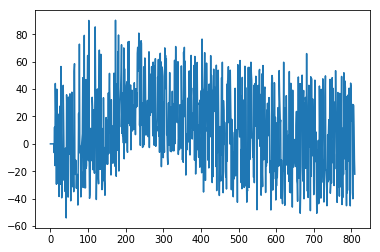

-200.0
81
-200.0
82
-200.0
83


KeyboardInterrupt: 

In [183]:
rewards = []
states_history = np.array([])
episode_returns = []
for k in range(iters):
    states_histories = [states_history.copy() for i in range(parallel_processes)]
    print(k)
    process = ThreadPool(processes=parallel_processes)
    out = process.map(traject,states_histories)
    process.close()
    process.join()
    trajectories,rewards_t,rw = list(zip(*out))
    rewards.extend(list(rw))
    episode_returns.extend(rewards_t)
    trajectories = reduce(lambda a,b: a+b,trajectories)
    act,obj,_,rews,_,old_policy,v,rews_disc_cuml,adv = zip(*trajectories)
    adv = torch.FloatTensor(adv)
    old_policy = torch.FloatTensor(old_policy)
    states_history = np.append(states_history,encoder.forward(obj).detach().numpy().reshape(-1))
    for t in range(train_pi_iter):
        new_policy = act_net.forward(obj,action=act)
        ratio = torch.exp(new_policy-old_policy)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
        optim_actor.zero_grad()
        loss_pi.backward()
        optim_actor.step()
        if (new_policy - old_policy).mean().item() > 1.5 * target_kl:
            print('early_stopping')
            break

    for t in range(train_v_iter):
        loss_v = ((crit_net.forward(obj) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
        optim_critic.zero_grad()
        loss_v.backward()
        optim_critic.step()
        
        
    if k % 10 == 0:
        clear_output(wait=True)
        print(k)
        plt.plot([sum(i) for i in episode_returns])
        plt.show()
        
        
    done = False
    obj = env.reset()
    rw = 0
    while not done:
        act = act_net.forward(obj,max_act=True)
        obj,reward,done,_ = env.step(act)
        rw += reward
        env.render()
    env.close()
    print(rw)

In [142]:
d = stats.norm(*stats.norm.fit(states_history))
pdfs = 1/d.pdf(states_history)
pdfs = pdfs/(pdfs.max()-pdfs.min())

In [143]:
pdfs.min()

0.0004784817276878792

In [144]:
pdfs.max()

1.000478481727688

In [145]:
(pdfs).min()

0.0004784817276878792

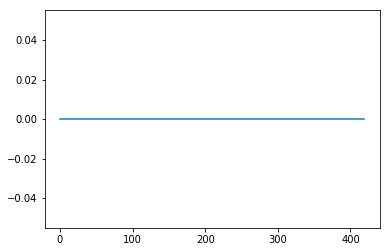

In [146]:
plt.plot(rewards)

In [123]:
len(states_history)/200

530.0

In [191]:
import time

In [205]:
done = False
obj = env.reset()
rw = 0
while not done:
# for r in range(800):
#     print('**********************************')
    act = k.forward(obj,max_act=True)
    time.sleep(0.02)
#     print(m.logits)
#     print(m.logits.argmax())
#     print(act)
    obj,reward,done,_ = env.step(act)
    rw += reward
    env.render()
env.close()
print(rw)

-16.0


In [193]:
env.close()

In [40]:
act

0

In [43]:
m.logits

tensor([-1.6989, -1.7558, -2.4567, -0.5823], grad_fn=<SubBackward0>)

In [198]:
k = torch.load('ppo_multitraj_pong_v2')

In [120]:
# torch.save(act_net,'ppo_multitraj_acrobat')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ActorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
